# Creating the AI Agent with some custom tools

In [28]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langchain.tools import Tool
from langgraph.prebuilt import ToolNode, tools_condition
from dotenv import load_dotenv
import os, requests
from langchain_ollama import ChatOllama

In [30]:
load_dotenv()

groq_api_key = os.getenv("GROQ_API_KEY")
langsmith_api_key = os.getenv("LANGSMITH_API_KEY")

os.environ["LANGCHAIN_API_KEY"] = langsmith_api_key
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph_Agent"

In [31]:
llm = ChatOllama(model="qwen3:8b")

## custom tools

In [32]:
def hello_tool_func(input: str) -> str:
    greeting_prompt = (
        f"Generate a friendly greeting for {input}. Keep it short and cheerful."
    )
    greeting_response = llm.invoke(greeting_prompt).content
    return greeting_response


hello_tool = Tool(
    name="hello_tool",
    func=hello_tool_func,
    description="A tool that greets the user with a hello message.",
)

In [33]:
def find_user_details(input: str) -> str:
    users = requests.get("https://jsonplaceholder.typicode.com/users").json()
    for user in users:
        if user["name"].lower() in input.lower():
            user_describe_prompt = f"Describe the user with details {user['name']}, Email: {user['email']}, Lives in {user['address']['city']} at {user['address']['suite']}. He works in {user['company']['name']}. Tell as if you are giving a brief introduction about the user. For example say the user name is ABC with email XYZ, lives in the city EFG and works in the company HIJ. Keep it short and concise."
            return llm.invoke(user_describe_prompt).content

    return "No user found with that name."


find_user_tool = Tool(
    name="find_user_tool",
    func=find_user_details,
    description="A tool that finds user details by name.",
)

In [34]:
tools = [hello_tool, find_user_tool]
llm = llm.bind_tools(tools=tools)

In [35]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [36]:
def chatbot(state: State) -> dict:
    return {"messages": [llm.invoke(state["messages"])]}

In [37]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile()

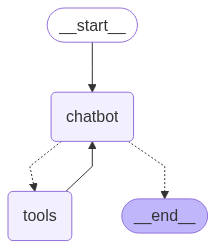

In [38]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [39]:
user_inputs = [
    "Hello, my name is Alice.",
    "Can you find a user with name Clementine Bauch?",
    "Can you find a user with name Patricia Lebsack?",
]

In [40]:
for user_input in user_inputs:
    events = graph.stream({"messages": [("user", user_input)]}, stream_mode="values")

    for event in events:
        print(event["messages"][-1].content)

Hello, my name is Alice.
<think>
Okay, let's see. The user introduced themselves as Alice. I need to respond appropriately. The available tools are hello_tool and find_user_tool. The hello_tool is for greeting, and find_user_tool is for finding user details by name.

Since the user provided their name, maybe I should use the find_user_tool to get more information about Alice. But wait, the find_user_tool's parameter is __arg1, which is a string. The description says it finds user details by name, so I should pass "Alice" as the argument. However, the user hasn't mentioned anything about needing user details yet. They just said hello. 

Alternatively, maybe I should first use the hello_tool to greet them. But the hello_tool's description says it greets with a hello message, and the parameter is __arg1, which is a string. Maybe the parameter is for the name to include in the greeting. So if I use hello_tool with "Alice", it would say hello to her. 

Wait, the user already said their name

KeyboardInterrupt: 